In [216]:
# Import libraries
import os
import tensorflow as tf
import keras
import pickle
import numpy as np
import path
import math
import scipy
import h5py
from tensorflow.keras.layers import Input, Add, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, ZeroPadding2D, Activation
from keras.layers import Convolution2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow

In [217]:
#identity block

In [218]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters # F1=64 , F2=64,256
    F1, F2, F3 = filters #
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X #storing the value of x in xshortcut because its changing from layer to layer 
    
    # First layer
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X) #APPLY batchnormalizaition into 3 RGB 
    X = Activation('relu')(X) #no vanishing gradient with relu

    # Second layer filters values 3X3 and 64 filters
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut, X]) 
#     X = X + X_shortcut (adding the x and the variable to do the activaition by relu )
    X = Activation('relu')(X) #implement  to transform all negative values to 0 fixing vanishing gradient issue  
    
    # identity block we have to have input size = output size
    
    return X

In [219]:
#convolution layer 
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block 
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
    

In [240]:
def ResNet50(input_shape=(64, 64, 3), classes=7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [241]:
model = ResNet50(input_shape = (64, 64, 3), classes = 7)

In [242]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

][0]             
__________________________________________________________________________________________________
activation_561 (Activation)     (None, 4, 4, 256)    0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_branch2b (Conv2D)         (None, 4, 4, 256)    590080      activation_561[0][0]             
__________________________________________________________________________________________________
bn4a_branch2b (BatchNormalizati (None, 4, 4, 256)    1024        res4a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_562 (Activation)     (None, 4, 4, 256)    0           bn4a_branch2b[0][0]              
__________________________________________________________________________________________________
res4a_branch2c (Conv2D)         (None, 4, 4, 1024)   263168      activation_562[0][0]      

In [223]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import tensorflow as tf

In [224]:


train_dir = r'C:\Windows\data\train'
test_dir =  r'C:\Windows\data\test'
val_dir =  r'C:\Windows\data\val'

In [225]:
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt
%matplotlib inline

In [226]:
image_gen_train = ImageDataGenerator(rescale=1./1040, 
                                     zoom_range=0.2, 
                                     rotation_range=65,
                                     shear_range=0.09,
                                     horizontal_flip=True,
                                     vertical_flip=True)

In [227]:
train_data_gen = image_gen_train.flow_from_directory(directory=train_dir, shuffle=True, target_size=(), class_mode='sparse')

Found 4618 images belonging to 7 classes.


In [234]:
image_gen_val = ImageDataGenerator(rescale=1./1040)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, directory=val_dir, target_size=(), class_mode='sparse')

Found 574 images belonging to 7 classes.


In [229]:
train_data_gen.class_indices.keys()

dict_keys(['FerryBoatSailing_ship', 'Fireboat_ship', 'container_ship', 'cruise_ship', 'freightBoat_ship', 'sailboat_ship', 'submarin_ship'])

In [230]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(7)])

In [231]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 111, 111, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 55, 55, 64)        18496     
_________________________________________________________________
flatten_14 (Flatten)         (None, 193600)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1355207   
Total params: 1,374,599
Trainable params: 1,374,599
Non-trainable params: 0
_________________________________________________________________


In [232]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [233]:
history = model.fit(train_data_gen,steps_per_epoch=len(train_data_gen)//batch_size, validation_data=val_data_gen, epochs=2)

Epoch 1/2
288/288 [==============================] - 122s 375ms/step - loss: 8.4642 - accuracy: 0.0504 - val_loss: 1.9459 - val_accuracy: 0.0767
Epoch 2/2
288/288 [==============================] - 92s 299ms/step - loss: 1.9459 - accuracy: 0.1093 - val_loss: 1.9459 - val_accuracy: 0.0767


In [235]:
preds = model.evaluate(train_data_gen)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1155/1155 [==============================] - 312s 267ms/step - loss: 1.9459 - accuracy: 0.1052
Loss = 1.9459103345870972
Test Accuracy = 0.1052403673529625


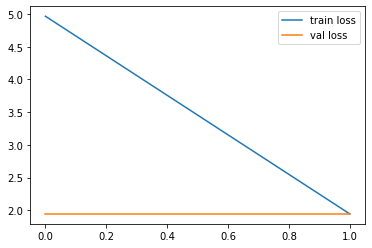

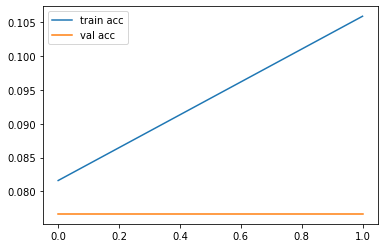

<Figure size 432x288 with 0 Axes>

In [236]:

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [237]:
#save the model as a h5 file
model.save("ship_classification_resnet50.h5")

In [238]:
from keras import models 

In [239]:
model=models.load_model("ship_classification_resnet50.h5")